In [14]:
! pip install ../amp/

Processing /home/paulina/PycharmProjects/amp/amp
  Created wheel for AMP: filename=AMP-0.1-cp37-none-any.whl size=20255 sha256=23eada7ce37fee2843e0e8a8ea8daf2140c58c439cd2409d6531d4a7a6bddf31
  Stored in directory: /tmp/pip-ephem-wheel-cache-iz7_oobv/wheels/5a/97/c5/bc2f754386f3f5c39a81497015c01e6e615d20c6bf8ff970e3
Successfully built AMP
  Found existing installation: AMP 0.1
    Uninstalling AMP-0.1:
      Successfully uninstalled AMP-0.1


# 0. Create directory structure

In [28]:
import os

folders = ['external', 'interim', 'processed', 'raw']
for folder in folders:
    try:
        os.makedirs(f'../data/{folder}')
    except:
        pass

For our purposes we are going to need 4 different subsets:

1. All available peptide sequences - **all peptides** 
2. Peptides with experimentally proven antimicrovial activity - **unlabelled positive dataset**
3. Peptides from Uniprot marked as lacking antimicrobial activity - **unlabelled negative dataset**
4. Peptides with experimentally proven antimicrobial activity with **measured MIC values**.

# 1. All peptides

## 1.1. Downloading the sequences from TrEMBL

The peptides are downloaded from The Uniprot Knowledgebase TrEMBL. **TrEMBL** consists of computationally analysed records awaiting full manual annotation, accounting to ~180,000,000 entries (*as for 01.04.2020*). 

Because AMPs are rarely longer than 200 peptides only sequences longer than 200 amino acids and consisting of standard amino acids were downloaded to *Uniprot_0_200.csv*, resulting in **60,112,952** sequences.

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)

from amp.data_utils import sequence
from amp.data_utils import download
from amp.data_utils import csv as amp_csv
from amp.data_utils import fasta

TREMBL = "ftp://ftp.ebi.ac.uk/pub/databases/uniprot/knowledgebase/uniprot_trembl.fasta.gz"
MIN_LENGTH = 0
MAX_LENGTH = 200 

In [ ]:
# download.download_uniprot(
#     source=TREMBL,
#     min_length=MIN_LENGTH,
#     max_length=MAX_LENGTH,
#     output = f'../data/raw/Uniprot_{MIN_LENGTH}_{MAX_LENGTH}.csv',
# )

## 1.2. Duplicate removal 

The duplicate sequences were subsequently removed yielding **49,852,155 sequences**.

In [1]:
import hashlib
import csv 

with open("../data/raw/Uniprot_0_200.csv", "r") as csv_input, \
        open("../data/interim/Uniprot_0_200_no_duplicates.csv", "w") as csv_output, \
        open("../data/interim/Uniprot_0_200_duplicates.csv", "w") as csv_duplicates:
    
    seen = set()  
    reader = csv.reader(csv_input)
    writer = csv.writer(csv_output)
    writer_duplicates = csv.writer(csv_duplicates)
    writer.writerow(['Name', 'Sequence'])
    for row in reader:  
        seq_hash = hashlib.md5(row[1].encode()).digest()  # hash the sequence
        if seq_hash not in seen: 
            seen.add(seq_hash)  
            writer.writerow(row)
        else:
            writer_duplicates.writerow(row)

## 1.3. Splitting into different lengths 

The main dataset consisting of sequences ranging from 1 to 200 in length was further splitted into 6 subsets varying in maximum sequence length: 15, 20, 25, 30, 50, or 100 amino acids.

In [4]:
max_lengths = [15, 20, 25, 30, 50, 100]
amp_csv.get_various_lengths_csv(
    max_lengths = max_lengths,
    min_length = MIN_LENGTH,
    input_path = f'../data/interim/Uniprot_{MIN_LENGTH}_{MAX_LENGTH}_no_duplicates.csv',
    output_to = '../data/interim'
)                

## 1.4. Summary

In [1]:
%%html
<style>
table {float:left}
</style>

| Maximum length | Number of sequences | File name         |
|----------------|---------------------|-------------------|
| 15             | 53,398              | Uniprot_0_15.csv  |
| 20             | 113,571             | Uniprot_0_20.csv  |
| 25             | 225,244             | Uniprot_0_25.csv  |
| 30             | 421,825             | Uniprot_0_30.csv  |
| 50             | 2,380,719           | Uniprot_0_50.csv  |
| 100            | 16,331,209          | Uniprot_0_100.csv |
| 200            | 49,852,155          | Uniprot_0_200.csv |

## 1.5. Splitting into test, train and validation subsets

For the model training purposes, each data set was divided into three subsets: train, test, and validation with 80%, 10%, 10% split. 

In [5]:
for max_len in [[15, 20, 25, 30, 50, 100]]:    
    amp_csv.CSVSplitter(
        input_file=f'../data/interim/Uniprot_{MIN_LENGTH}_{max_len}.csv',
        output_to='../data/processed',
        min_length=MIN_LENGTH,
        max_length=max_len,
        test_size=0.1,
        val_size=0.1,
    ).split()

# 2. Unlabelled positive dataset

## 2.1. Merging available datasets

The AMP unlabelled dataset contains the sequences from:
- dbAMP (Jhong et al. (2019))
- AMP Scanner (Veltri et al. (2019))
- DRAMP database (Kang et al. (2019))


In [6]:
!cat data/external/*.fasta > data/interim/unlabelled_positive.fasta

## 2.2. Converting to csv

Additionally check if the sequences consist only of standard amino acids.

In [3]:
fasta.fasta2csv(
    fasta_input='../data/interim//unlabelled_positive.fasta',
    csv_output='../data/interim/unlabelled_positive.csv'
)

## 2.3. Removing duplicates

In [32]:
# ! awk -F, '!x[$2]++' ../data/interim/unlabelled_positive.csv > ../data/processed/unlabelled_positive.csv
! cdhit -i ../data/interim/unlabelled_positive.csv -o ../data/processed/unlabelled_positive_40.csv -c 0.8 -T 4 -n 2 -M 2000


Program: CD-HIT, V4.7 (+OpenMP), Jul 01 2017, 08:43:07
Command: cdhit -i ../data/interim/unlabelled_positive.csv -o
         ../data/processed/unlabelled_positive_40.csv -c 0.8 -T
         4 -n 2 -M 2000

Started: Thu Jun 18 14:33:55 2020
                            Output                              
----------------------------------------------------------------
Your word length is 2, using 5 may be faster!
Discarding invalid sequence or sequence without identifier and description!





















































































































































































































































































































































































































































































































































































































































































































































total seq: 0
longest and shortest : 0 and 18446744073709551615
Total letters: 0
Sequences have been sorted

Approximated minimal memory consumption:
Sequence        : 0M
Buffer          : 4 X 10M = 41M
Table           : 2 X 0M = 0M
Miscellaneous   : 0M
Total           : 41M

Table limit with the given memory limit:
Max number of representatives: 4000000
Max number of word counting entries: 244753580


        0  finished          0  clusters

Apprixmated maximum memory consumption: 41M
writing new database
writing clustering information
program completed !

Total CPU time 0.12


## 2.4. Summary

The final length of the positive dataset is **20,313 sequences.**



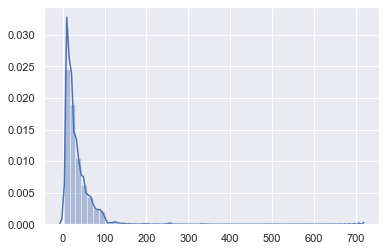

In [3]:
positive = pd.read_csv('../data/processed/unlabelled_positive.csv')
positive_seq = positive['Sequence'].tolist()
positive_lengths = [len(seq) for seq in positive_seq]

sns.distplot(positive_lengths)
plt.show()

# 3. Unlabelled negative dataset

## 3.1. Manual UniProt search with filters:
  - exclude entries that match the following keywords: antimicrobial, antibiotic, antiviral, antifungal, effector or excreted. 
  - sequences of length between 8 and 200 amino acids
  - required subcellular location: cytoplasm 

Resulting file with **1,757,637** sequences was saved as *data/raw/Uniprot_0_200_negative.fasta*

## 3.2. CD-HIT - remove sequences sharing ≥40% sequence identity.

Resulting file was saved as *data/interim/uniprot_negatives_cdhit_40.fasta*

In [ ]:
! cdhit -i ../data/raw/Uniprot_0_200_negative.fasta -o ../data/interim/uniprot_negatives_cdhit_40.fasta -c 0.4 -T 4 -n 2 -M 2000


## 3.3. Converting to csv:

Additionally check if the sequences consist only of standard amino acids.

In [3]:
fasta.fasta2csv(
    fasta_input='../data/interim/uniprot_negatives_cdhit_40.fasta',
    csv_output='../data/processed/unlabelled_negative.csv'
)

## 3.4. Summary

The final length of the negative dataset is **145,846 sequences.**


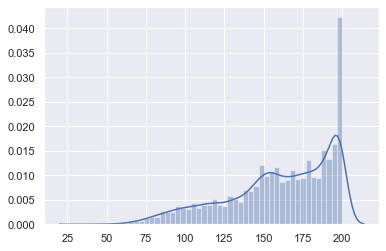

In [8]:
negative = pd.read_csv('../data/processed/unlabelled_negative.csv')
negative_seq = negative['Sequence'].tolist()
negative_lengths = [len(seq) for seq in negative_seq]

sns.distplot(negative_lengths)
plt.show()

In [9]:
positive_lengths = [seq for seq in negative_seq if len(seq) < 26]
len(positive_lengths)

0

# 4. Peptides with experimentally proven antimicrobial activity with measured MIC values.

This pipeline is based on Zack Witten AMP repository. 

The dataset used was scraped by Witten and Witten in 2019 from following databases: APD, DADP, DBAASP, DRAMP, and YADAMP.

In [10]:
witten = 'https://github.com/zswitten/Antimicrobial-Peptides/blob/master/data/grampa.csv?raw=true'
data = pd.read_csv(witten)
# Remove unit column and Unnamed: 0 as they don't provide any information 
data = data.drop(columns=['unit', 'Unnamed: 0'])

All sequences with modification other than C-terminal amidation and disulfide bonds, which are fairly common among AMPs, should be removed. The effect of other modifications on the peptide activity could be a subject of another work. 
All sequences from YADAMP database must be removed for having no modification data unless that sequence is in another database.


In [16]:
print("Dataframe length before excluding modifications:", len(data))
data = data.loc[data.has_unusual_modification == False]
data['_datasource_has_modifications'] = data.database != 'YADAMP'
sequences_containing_modifications = set(data.loc[data.database != 'YADAMP', 'sequence'])
data['_sequence_has_modifications'] = data['sequence'].isin(sequences_containing_modifications)
data['modification_verified'] = data['_sequence_has_modifications'] | data['_datasource_has_modifications']
data = data.loc[data.modification_verified == True]
print("Dataframe length after excluding unusual and unverified modifications:", len(data))

Dataframe length before excluding modifications: 44999
Dataframe length after excluding unusual and unverified modifications: 44999


As mentioned in Vishnepolsky et al. (2018), it has been reported that the same peptide can have different MIC values for different bacterium species, or even the different strains of the same species. Therefore it is absolutely necessary to narrow down the dataset. According to Witten and Witten it is possible to group the peptides according to the gram type into gram-negative and gram-positive antibiotic activity.

The number of available measurements for specific species is the greatest for E. coli (gram-negative) and S. aureus (gram-positive). We could treat those two species as the representants of the two gram types. The plots in Witten paper suggest that an AMP designed for effectiveness against E. coli would also likely be effective against other gram-negative pathogens.

To begin, we will select only those peptides which have MIC values measured against E. coli strains. Of 8049 entries only 4546 of them are unique sequences. As we need a single measurement for each peptide, all the measurements for a given peptide are being averaged.

In [20]:
data.groupby("bacterium").size().sort_values(0, ascending=False)
ecoli_df = data[data.bacterium == "E. coli"]
print(f'Number of entries: {len(ecoli_df)}, number of unique sequences: {ecoli_df.sequence.nunique()}')
ecoli_df = ecoli_df.groupby("sequence").mean().reset_index().dropna()
ecoli_df = ecoli_df[["sequence", "value"]]
print("Dataframe length for E.coli bacteria:", len(ecoli_df))


Number of entries: 8049, number of unique sequences: 4546
Dataframe length for E.coli bacteria: 4546


In [21]:
ecoli_df.to_csv('../data/processed/mic_data.csv')